# 2024 NBA Future Analytics Stars Coding Exercise

### Neural Network Using TensorFlow

#### Tomas Kersulis

In [96]:
# import needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense

In [103]:
# Get data from csv file
df = pd.read_csv('fas_2024.csv',sep=',')
player_stats = df.values[:,2:] # Stats for all players for months of October and November
real_three_pct = df.values[:,1] # Season long 3 pt percentage

names = df.values[:,0]
test_players = real_three_pct[:20]
print(test_players)
test_names = [names[np.where(real_three_pct == x)][0] for x in test_players]
print(test_names)

[0.43700000000000006 0.435 0.43200000000000005 0.42200000000000004
 0.42100000000000004 0.418 0.41600000000000004 0.41200000000000003
 0.41200000000000003 0.41 0.41 0.409 0.40700000000000003 0.406
 0.40399999999999997 0.40299999999999997 0.40299999999999997
 0.39899999999999997 0.396 0.395]
['Malcolm Brogdon', 'Tyrese Maxey', 'Stephen Curry', 'Kentavious Caldwell-Pope', 'Jevon Carter', 'Jalen Brunson', 'Michael Porter Jr.', 'Klay Thompson', 'Klay Thompson', 'Darius Garland', 'Darius Garland', 'Bojan Bogdanovic', 'Tyrese Haliburton', 'Jamal Murray', 'Kevin Durant', 'Jerami Grant', 'Jerami Grant', "D'Angelo Russell", 'Andrew Wiggins', 'Norman Powell']


In [83]:
# Create neural network
class NeuralNetwork:
    """
    A neural network created to assist in predicting NBA player statistics.
    """
    def __init__(self, input_dimension, width_list):
        """
        Initialize a NeuralNetwork with a specified input dimension and width_list to
        define the number of hidden layers and how wide each of these layers are in
        the NeuralNetwork.
        
        Attributes:
            input_dimension     The number of inputs into the first layer of the NeuralNetwork
            width_list          An int list of the the width (number of nodes in a layer) of
                                of each hidden layer of the NeuralNetwork, excluding the input
                                and output layer (i.e. for a NeuralNetwork with one hidden
                                layer of width 50, width_list is [50])
        """
        self.model = Sequential()
        self.model.add(Dense(width_list[0], input_dim=input_dimension,
            activation='relu'))
        for layer in width_list[1:]:
            self.model.add(Dense(layer, activation='relu'))
        self.model.add(Dense(1, activation='linear'))
        self.model.compile(loss='mean_squared_error', optimizer='adam')

In [84]:
# randomly split the data into a 60/20/20 training/validation/test split
def data_split(player_stats, real_three_pct):
    """
    Randomly split the data given into a 60/20/20 training/validation/test split.
    
    Attributes:
        player_stats        Two-dimensional array for the input data player stats
                            for the months of October and November where the rows
                            are each player's stats and the columns are the stat
                            for each player
        real_three_pct      One-dimensional array for player's season long three
                            point percentage
    """
    n_players = len(player_stats)
    player_indexes = np.arange(n_players)
    
    # Randomly assign the players to the training group
    training_indexes = np.random.choice(player_indexes, int(n_players * 0.6), replace=False)
    training_x = player_stats[training_indexes]
    training_y = real_three_pct[training_indexes]
    
    # Randomly assign the players to the validation group
    non_training_players = n_players - len(training_indexes)
    validation_indexes = np.ones(n_players) / non_training_players
    validation_indexes[training_indexes] = 0
    validation_indexes = np.random.choice(player_indexes, int(non_training_players / 2), p=validation_indexes, replace=False)
    validation_x = player_stats[validation_indexes]
    validation_y = real_three_pct[validation_indexes]
    
    # Randomly assign the players to the testing group
    testing_indexes = np.ones(n_players, bool)
    testing_indexes[training_indexes] = False
    testing_indexes[validation_indexes] = False
    testing_indexes = player_indexes[testing_indexes]
    testing_x = player_stats[testing_indexes]
    testing_y = real_three_pct[testing_indexes]
    
    # return the resulting split
    # x: model input data, y: real output data
    return np.asarray(training_x).astype(np.float32), \
            np.asarray(training_y).astype(np.float32), \
            np.asarray(validation_x).astype(np.float32), \
            np.asarray(validation_y).astype(np.float32), \
            np.asarray(testing_x).astype(np.float32), \
            np.asarray(testing_y).astype(np.float32)

In [85]:
def validation(training_x, training_y, validation_x, validation_y):
    """
    Perform validation on the testing split to find the best hyperparameters for the
    neural network: the depth and width of the hidden layers.
    
    Attributes:
        training_x       training input data
        training_y       training real output data
        validation_x     validation input data
        validation_y     validation real output data
    """
    num_input_features = len(training_x[0])
    best_mse = float('inf')
    mse_dict = {}
    for depth in range(3, 6):
        for width in range(10, 110, 10):
            # Create the neural network with the hyperparameters
            neural_network = NeuralNetwork(num_input_features, [width] * depth)

            # Fit the neural network
            neural_network.model.fit(training_x, training_y, epochs=1000, batch_size=10)

            # Get predictions for validation data
            predicted_y = neural_network.model.predict(validation_x)

            # Calculate the mean squared error
            mse = mean_squared_error(validation_y, predicted_y)
            mse_dict[(depth, width)] = mse
            if mse < best_mse:
                best_mse = mse
                best_hyperparameters = (depth, width)
    
    # Return the best hyperparameters
    return best_hyperparameters, mse_dict

In [88]:
def testing(training_x, training_y, testing_x, testing_y, depth, width):
    """
    Test the neural network to find the mean squared error of the model using
    the best hyperparameters found during validation for the depth and width
    of the hidden layers of the neural network.
    
    Attributes:
        training_x       training input data
        training_y       training real output data
        testing_x        testing input data
        testing_y        testing real output data
        depth            number of hidden layers in neural network
        width            number of nodes in each hidden layer
    """
    num_input_features = len(training_x[0])
    
    # Create the neural network with the hyperparameters
    neural_network = NeuralNetwork(num_input_features, [width] * depth)
    
    # Fit the neural network
    neural_network.model.fit(training_x, training_y, epochs=1000, batch_size=10)

    # Get predictions for validation data
    predicted_y = neural_network.model.predict(testing_x)

    # Calculate the mean squared error
    mse = mean_squared_error(testing_y, predicted_y)
    
    return mse

In [ ]:
# Validate the model
training_x, training_y, validation_x, validation_y, testing_x, testing_y = data_split(player_stats, real_three_pct)
(depth, width), mse_dict = validation(training_x, training_y, validation_x, validation_y)

print("Mean Squared Errors for different hyperparameters:", mse_dict)
print("Best hyperparameters", (depth, width))

In [89]:
# Test the model
mse = testing(training_x, training_y, testing_x, testing_y, depth, width)
print("Mean Squared Error of Model:", mse)

Epoch 1/1000
7/7 [==============================] - 1s 2ms/step - loss: 14.6729
Epoch 2/1000
7/7 [==============================] - 0s 3ms/step - loss: 1.2799
Epoch 3/1000
7/7 [==============================] - 0s 3ms/step - loss: 0.4643
Epoch 4/1000
7/7 [==============================] - 0s 3ms/step - loss: 0.1996
Epoch 5/1000
7/7 [==============================] - 0s 3ms/step - loss: 0.1820
Epoch 6/1000
7/7 [==============================] - 0s 3ms/step - loss: 0.0633
Epoch 7/1000
7/7 [==============================] - 0s 3ms/step - loss: 0.0676
Epoch 8/1000
7/7 [==============================] - 0s 3ms/step - loss: 0.0458
Epoch 9/1000
7/7 [==============================] - 0s 3ms/step - loss: 0.0431
Epoch 10/1000
7/7 [==============================] - 0s 3ms/step - loss: 0.0297
Epoch 11/1000
7/7 [==============================] - 0s 3ms/step - loss: 0.0212
Epoch 12/1000
7/7 [==============================] - 0s 3ms/step - loss: 0.0178
Epoch 13/1000
7/7 [=============================

7/7 [==============================] - 0s 3ms/step - loss: 0.0011
Epoch 104/1000
7/7 [==============================] - 0s 3ms/step - loss: 0.0017
Epoch 105/1000
7/7 [==============================] - 0s 3ms/step - loss: 0.0014
Epoch 106/1000
7/7 [==============================] - 0s 3ms/step - loss: 0.0019
Epoch 107/1000
7/7 [==============================] - 0s 3ms/step - loss: 0.0027
Epoch 108/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0032
Epoch 109/1000
7/7 [==============================] - 0s 3ms/step - loss: 0.0031
Epoch 110/1000
7/7 [==============================] - 0s 3ms/step - loss: 0.0034
Epoch 111/1000
7/7 [==============================] - 0s 3ms/step - loss: 0.0022
Epoch 112/1000
7/7 [==============================] - 0s 3ms/step - loss: 0.0015
Epoch 113/1000
7/7 [==============================] - 0s 3ms/step - loss: 0.0017
Epoch 114/1000
7/7 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 115/1000
7/7 [=======================

Epoch 202/1000
7/7 [==============================] - 0s 3ms/step - loss: 3.9538e-04
Epoch 203/1000
7/7 [==============================] - 0s 3ms/step - loss: 5.0314e-04
Epoch 204/1000
7/7 [==============================] - 0s 3ms/step - loss: 3.7919e-04
Epoch 205/1000
7/7 [==============================] - 0s 3ms/step - loss: 3.6009e-04
Epoch 206/1000
7/7 [==============================] - 0s 3ms/step - loss: 3.1003e-04
Epoch 207/1000
7/7 [==============================] - 0s 3ms/step - loss: 3.2284e-04
Epoch 208/1000
7/7 [==============================] - 0s 3ms/step - loss: 3.1121e-04
Epoch 209/1000
7/7 [==============================] - 0s 3ms/step - loss: 2.7344e-04
Epoch 210/1000
7/7 [==============================] - 0s 3ms/step - loss: 2.3209e-04
Epoch 211/1000
7/7 [==============================] - 0s 3ms/step - loss: 3.2803e-04
Epoch 212/1000
7/7 [==============================] - 0s 3ms/step - loss: 3.0246e-04
Epoch 213/1000
7/7 [==============================] - 0s 3ms/step

Epoch 299/1000
7/7 [==============================] - 0s 3ms/step - loss: 0.0095
Epoch 300/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0065
Epoch 301/1000
7/7 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch 302/1000
7/7 [==============================] - 0s 3ms/step - loss: 0.0040
Epoch 303/1000
7/7 [==============================] - 0s 3ms/step - loss: 0.0085
Epoch 304/1000
7/7 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 305/1000
7/7 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 306/1000
7/7 [==============================] - 0s 3ms/step - loss: 0.0026
Epoch 307/1000
7/7 [==============================] - 0s 3ms/step - loss: 0.0024
Epoch 308/1000
7/7 [==============================] - 0s 3ms/step - loss: 0.0014
Epoch 309/1000
7/7 [==============================] - 0s 3ms/step - loss: 8.6642e-04
Epoch 310/1000
7/7 [==============================] - 0s 3ms/step - loss: 4.9327e-04
Epoch 311/1000
7/7 [

7/7 [==============================] - 0s 4ms/step - loss: 3.2118e-04
Epoch 494/1000
7/7 [==============================] - 0s 3ms/step - loss: 2.5579e-04
Epoch 495/1000
7/7 [==============================] - 0s 4ms/step - loss: 2.5046e-04
Epoch 496/1000
7/7 [==============================] - 0s 3ms/step - loss: 2.4367e-04
Epoch 497/1000
7/7 [==============================] - 0s 3ms/step - loss: 2.5347e-04
Epoch 498/1000
7/7 [==============================] - 0s 3ms/step - loss: 2.8567e-04
Epoch 499/1000
7/7 [==============================] - 0s 3ms/step - loss: 2.9581e-04
Epoch 500/1000
7/7 [==============================] - 0s 4ms/step - loss: 2.6224e-04
Epoch 501/1000
7/7 [==============================] - 0s 4ms/step - loss: 2.8573e-04
Epoch 502/1000
7/7 [==============================] - 0s 3ms/step - loss: 2.1890e-04
Epoch 503/1000
7/7 [==============================] - 0s 3ms/step - loss: 2.5850e-04
Epoch 504/1000
7/7 [==============================] - 0s 3ms/step - loss: 2.8007

Epoch 685/1000
7/7 [==============================] - 0s 4ms/step - loss: 1.6996e-04
Epoch 686/1000
7/7 [==============================] - 0s 4ms/step - loss: 1.9558e-04
Epoch 687/1000
7/7 [==============================] - 0s 5ms/step - loss: 1.2908e-04
Epoch 688/1000
7/7 [==============================] - 0s 4ms/step - loss: 1.8824e-04
Epoch 689/1000
7/7 [==============================] - 0s 4ms/step - loss: 1.9950e-04
Epoch 690/1000
7/7 [==============================] - 0s 5ms/step - loss: 1.7251e-04
Epoch 691/1000
7/7 [==============================] - 0s 3ms/step - loss: 1.2819e-04
Epoch 692/1000
7/7 [==============================] - 0s 3ms/step - loss: 1.6177e-04
Epoch 693/1000
7/7 [==============================] - 0s 2ms/step - loss: 2.6474e-04
Epoch 694/1000
7/7 [==============================] - 0s 2ms/step - loss: 1.5363e-04
Epoch 695/1000
7/7 [==============================] - 0s 2ms/step - loss: 1.3843e-04
Epoch 696/1000
7/7 [==============================] - 0s 3ms/step

7/7 [==============================] - 0s 3ms/step - loss: 2.6833e-05
Epoch 878/1000
7/7 [==============================] - 0s 3ms/step - loss: 3.0743e-05
Epoch 879/1000
7/7 [==============================] - 0s 3ms/step - loss: 4.1539e-05
Epoch 880/1000
7/7 [==============================] - 0s 3ms/step - loss: 3.0501e-05
Epoch 881/1000
7/7 [==============================] - 0s 3ms/step - loss: 9.4858e-05
Epoch 882/1000
7/7 [==============================] - 0s 3ms/step - loss: 9.3648e-05
Epoch 883/1000
7/7 [==============================] - 0s 3ms/step - loss: 1.0487e-04
Epoch 884/1000
7/7 [==============================] - 0s 3ms/step - loss: 1.6214e-04
Epoch 885/1000
7/7 [==============================] - 0s 3ms/step - loss: 1.8013e-04
Epoch 886/1000
7/7 [==============================] - 0s 3ms/step - loss: 2.6709e-04
Epoch 887/1000
7/7 [==============================] - 0s 3ms/step - loss: 3.3408e-04
Epoch 888/1000
7/7 [==============================] - 0s 4ms/step - loss: 3.3065

Text(0, 0.5, 'Count')

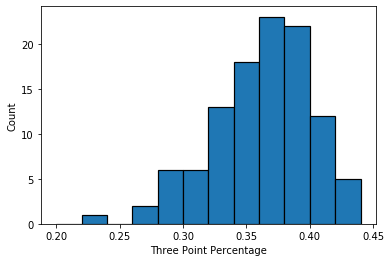

In [95]:
plt.hist(real_three_pct, density=False, edgecolor='black', linewidth=1.2, bins=np.arange(0.20, 0.45, 0.02))
plt.xlabel("Three Point Percentage")
plt.ylabel("Count")

In [98]:
plt.scatter(np.arange(1, 10))
plt.scatter(np.arange(5, 15))

TypeError: scatter() missing 1 required positional argument: 'y'